In [1]:
from platform import python_version
print(python_version())

3.7.10


A: The usage of the data set is unrestricted. But you should provide the link to our original download site, acknowledge the NIH Clinical Center and provide a citation to our CVPR 2017 paper

A: ‘No finding’ means the 14 listed disease patterns are not found in the image. 

https://www.kaggle.com/nih-chest-xrays/data

Citations
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community

Original source files and documents: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

### Context Behind Dataset for Final Writeup:

Dataset was gathered by the NIH and contains over 100,000 anonymized chest x-ray images from more than 30,000 patients.  

# Goal
The goal is to use a simple model to classify x-ray images in Keras

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import tensorflow

In [4]:
all_xray_df = pd.read_csv('../data/Data_Entry_2017.csv')
folderlist = glob(os.path.join('../data', 'images*'))
imglist = []
for folder in folderlist:
    tmp = glob(os.path.join(folder, "images", "*.png"))
    imglist += tmp
all_image_paths = {os.path.basename(x): x for x in imglist}
#{k:all_image_paths[k] for k in all_image_paths.keys()[:5]}
list(all_image_paths.items())[:4]
# all_image_paths = {os.path.basename(x): x for x in 
#                    glob(os.path.join('.', 'data', 'images*', '*.png'))}



[('00018942_001.png', '../data/images_009/images/00018942_001.png'),
 ('00020323_001.png', '../data/images_009/images/00020323_001.png'),
 ('00018730_001.png', '../data/images_009/images/00018730_001.png'),
 ('00019551_000.png', '../data/images_009/images/00019551_000.png')]

In [5]:
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
num_selected = 10000
tmp = {key: all_image_paths[key] for key in sorted(list(all_image_paths.keys()))[num_selected:]}
print(list(tmp.items())[:4])
all_xray_df['path'] = all_xray_df['Image Index'][num_selected:].map(tmp.get)
all_xray_df = all_xray_df[num_selected:]
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120
[('00002587_005.png', '../data/images_002/images/00002587_005.png'), ('00002588_000.png', '../data/images_002/images/00002588_000.png'), ('00002589_000.png', '../data/images_002/images/00002589_000.png'), ('00002589_001.png', '../data/images_002/images/00002589_001.png')]


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
94305,00024100_000.png,Infiltration,0,24100,64,M,PA,2992,2991,0.143,0.143,NaN,../data/images_010/images/00024100_000.png
69735,00017184_000.png,Infiltration,0,17184,62,M,PA,2500,2048,0.168,0.168,NaN,../data/images_008/images/00017184_000.png
98287,00025955_000.png,Infiltration|Mass,0,25955,44,F,PA,2626,2481,0.143,0.143,NaN,../data/images_011/images/00025955_000.png


In [6]:
label_counts = all_xray_df['Finding Labels'].value_counts()
label_counts

No Finding                                                                        54652
Infiltration                                                                       8734
Atelectasis                                                                        3848
Effusion                                                                           3659
Nodule                                                                             2495
Mass                                                                               2015
Pneumothorax                                                                       1972
Effusion|Infiltration                                                              1511
Atelectasis|Infiltration                                                           1237
Consolidation                                                                      1199
Atelectasis|Effusion                                                               1091
Pleural_Thickening              

# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

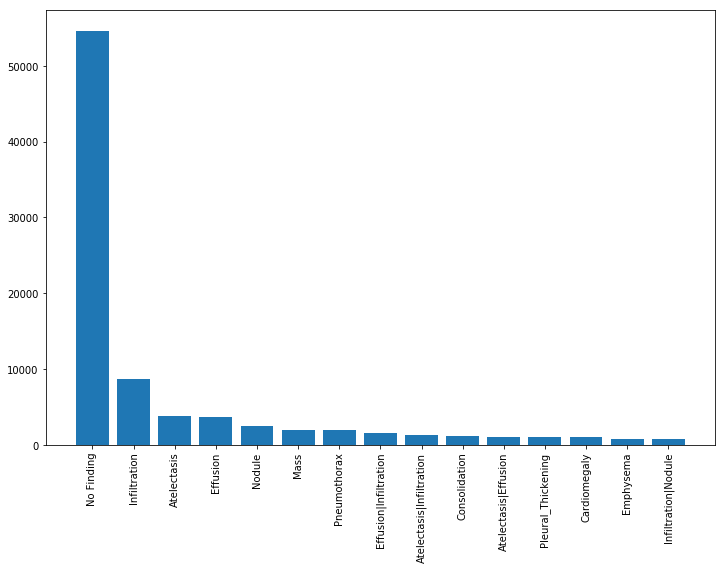

In [7]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [8]:
n_priorities = 4
priority1=['Pneumothorax']
priority2=['Pneumonia','Edema']
priority3=['Atelectasis','Cardiomegaly','Consolidation','Effusion','Emphysema','Fibrosis','Infiltration','Mass','Nodule','Pleural_Thickening']
priority4=['No Finding']

In [9]:
def priority_val(x):
    if any(item in priority1 for item in x):
        return 'priority1'
    elif any(item in priority2 for item in x):
        return 'priority2'
    elif any(item in priority3 for item in x):
        return 'priority3'
    elif any(item in priority4 for item in x):
        return 'priority4'
    
    

In [10]:
from itertools import chain
all_xray_df['Priority Label']=all_xray_df['Finding Labels'].map(lambda x: priority_val(x.split('|')))
all_xray_df['Priority Label'].sample(3)

48539     priority4
33493     priority4
101426    priority3
Name: Priority Label, dtype: object

In [11]:
#all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
54678,00013675_000.png,No Finding,0,13675,32,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
32893,00008612_003.png,Mass,3,8612,39,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21771,00005776_007.png,No Finding,7,5776,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [13]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 10670), ('Cardiomegaly', 2476), ('Consolidation', 4271), ('Edema', 2150), ('Effusion', 12410), ('Emphysema', 2295), ('Fibrosis', 1407), ('Infiltration', 18291), ('Mass', 5454), ('No Finding', 54652), ('Nodule', 5887), ('Pleural_Thickening', 3060), ('Pneumonia', 1296), ('Pneumothorax', 4862)]


In [14]:

res = [i for i, val in enumerate(list(all_xray_df['Priority Label'])) if val == None]


In [15]:
all_xray_df['Priority Label']
res = [i for i, val in enumerate(list(all_xray_df['Priority Label'])) if val == None]
print(res)

[1589, 1590, 1591, 1592, 2428, 2525, 5023, 5024, 5579, 6034, 9541, 9590, 11551, 12815, 13240, 14244, 14781, 15532, 15536, 16160, 18209, 19618, 20263, 20280, 20754, 22253, 22528, 23133, 23135, 23137, 24265, 27971, 28351, 36105, 36669, 37468, 39653, 40594, 40972, 42639, 43035, 43038, 43043, 43048, 44689, 44822, 44823, 44824, 46170, 46797, 48269, 59434, 59781, 62160, 63688, 64700, 67454, 67543, 67544, 70765, 73006, 74376, 74874, 74875, 74876, 74877, 76994, 77002, 77003, 78462, 78588, 78821, 81356, 84724, 84734, 84878, 87051, 90738, 90847, 92747, 93654, 95367, 97271, 97273, 97276, 97927, 98497, 99616]


In [16]:
res = [i for i, val in enumerate(list(all_xray_df['Priority Label'])) if val == None]
res
rows=all_xray_df.index[res]
all_xray_df=all_xray_df.drop(rows)

In [17]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
90459,00022519_002.png,No Finding,2,22519,64,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
110901,00030246_001.png,No Finding,1,30246,68,M,PA,2021,2010,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
80698,00019823_015.png,Infiltration,15,19823,30,M,PA,2966,2973,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
np.unique(list(all_xray_df['Priority Label']))

array(['priority1', 'priority2', 'priority3', 'priority4'], dtype='<U9')

In [19]:
all_priorities = np.unique(all_xray_df['Priority Label'])
#all_priorities = [x for x in all_priorities if len(x)>0]
all_priorities

array(['priority1', 'priority2', 'priority3', 'priority4'], dtype=object)

In [20]:
print('All Priorities ({}): {}'.format(len(all_priorities), all_priorities))
for p_label in all_priorities:
    if len(p_label)>1: # leave out empty labels
        all_xray_df[p_label] = all_xray_df['Priority Label'].map(lambda finding: 1.0 if p_label in finding else 0)
all_xray_df.sample(3)

All Priorities (4): ['priority1' 'priority2' 'priority3' 'priority4']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,priority1,priority2,priority3,priority4
38422,00010044_001.png,Atelectasis,1,10044,62,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25864,00006801_000.png,No Finding,0,6801,52,M,PA,2500,2048,0.171,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
96770,00025513_010.png,Infiltration,10,25513,10,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
for c_label, s_count in zip(all_labels, np.mean(all_xray_df[all_labels].values,0)):
    print('%s: %f' % (c_label, s_count))
arrivals=np.array(np.mean(all_xray_df[all_labels].values,0))
arrivals=arrivals/arrivals.sum(axis=0,keepdims=True)
disease_priority=np.array([[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,1,0,0],[0,0,1,0],
                  [0,0,1,0],[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,0,0,1],
                  [0,0,1,0],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
priority_cost=[8,4,2,1]
priority_costs=[8,4,2,1]
#print(disease_priority)
print(priority_cost)
costs=np.matmul(disease_priority,priority_cost)
print(arrivals)
priority_arrivals=np.array(np.mean(all_xray_df[all_priorities].values,0))
rho_s=0.95
print(priority_arrivals)

Atelectasis: 0.104575
Cardiomegaly: 0.024267
Consolidation: 0.041859
Edema: 0.021072
Effusion: 0.121629
Emphysema: 0.022493
Fibrosis: 0.013790
Infiltration: 0.179267
Mass: 0.053454
No Finding: 0.535636
Nodule: 0.057698
Pleural_Thickening: 0.029991
Pneumonia: 0.012702
Pneumothorax: 0.047652
[8, 4, 2, 1]
[0.08259729 0.01916691 0.03306214 0.01664331 0.09606676 0.01776577
 0.01089169 0.14159203 0.04221983 0.42306531 0.04557172 0.02368769
 0.01003244 0.03763711]
[0.04765172 0.0300886  0.3866238  0.53563588]


In [22]:
priority_arrivals=priority_arrivals/priority_arrivals.sum(axis=0,keepdims=True)
priority_service=np.repeat(1/rho_s,n_priorities)
print(costs)
service=np.repeat(1/rho_s,len(all_labels))
print(service)
rho=arrivals/service
print(rho)
priority_rho = priority_arrivals/priority_service
print(priority_rho)
parameters=pd.DataFrame(np.column_stack((all_labels,np.mean(all_xray_df[all_labels].values,0),arrivals,service,costs,rho)))

[2 2 2 4 2 2 2 2 2 1 2 2 4 8]
[1.05263158 1.05263158 1.05263158 1.05263158 1.05263158 1.05263158
 1.05263158 1.05263158 1.05263158 1.05263158 1.05263158 1.05263158
 1.05263158 1.05263158]
[0.07846742 0.01820856 0.03140903 0.01581115 0.09126342 0.01687748
 0.01034711 0.13451243 0.04010884 0.40191205 0.04329313 0.02250331
 0.00953081 0.03575526]
[0.04526913 0.02858417 0.36729261 0.50885408]


In [23]:
costs=np.array(pd.to_numeric(pd.Series(parameters[4].values)))
arrivals=np.array(pd.to_numeric(pd.Series(parameters[2].values)))
service=np.array(pd.to_numeric(pd.Series(parameters[3].values)))
rho=np.array(pd.to_numeric(pd.Series(parameters[5].values)))

In [24]:
print(all_xray_df[all_labels].sum())
print(all_xray_df[all_priorities].sum())

Atelectasis           10670.0
Cardiomegaly           2476.0
Consolidation          4271.0
Edema                  2150.0
Effusion              12410.0
Emphysema              2295.0
Fibrosis               1407.0
Infiltration          18291.0
Mass                   5454.0
No Finding            54652.0
Nodule                 5887.0
Pleural_Thickening     3060.0
Pneumonia              1296.0
Pneumothorax           4862.0
dtype: float64
priority1     4862.0
priority2     3070.0
priority3    39448.0
priority4    54652.0
dtype: float64


In [ ]:
all_xray_df1 = all_xray_df[all_xray_df['Priority Label'] == "priority1"].sample(frac=5,replace=True)


In [ ]:
all_xray_df2 = all_xray_df[all_xray_df['Priority Label'] == "priority2"].sample(frac=10,replace=True)

In [ ]:
all_xray_df3 = all_xray_df[all_xray_df['Priority Label'] == "priority3"]

In [ ]:
all_xray_df_bal = pd.concat([all_xray_df,all_xray_df1,all_xray_df2,all_xray_df3],ignore_index=True)

In [ ]:
all_xray_df_bal=all_xray_df_bal.sample(frac=0.5)

In [ ]:
print(all_xray_df_bal[all_priorities].sum())

priority1    14598.0
priority2    16972.0
priority3    39436.0
priority4    27239.0
dtype: float64


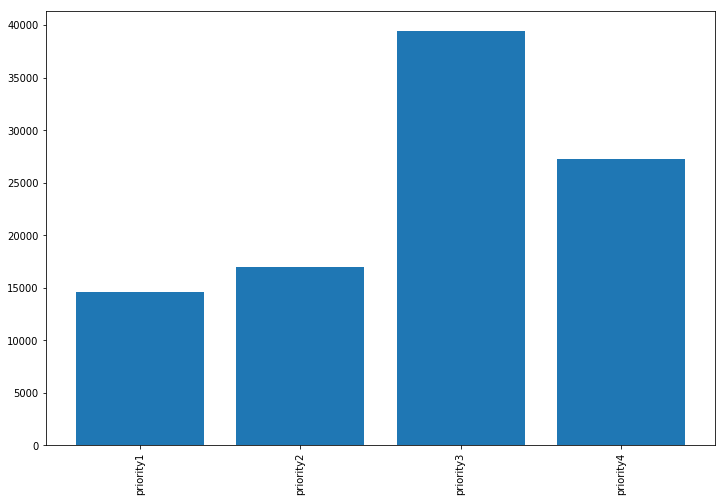

In [ ]:
label_counts = all_xray_df_bal[all_priorities].sum()
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

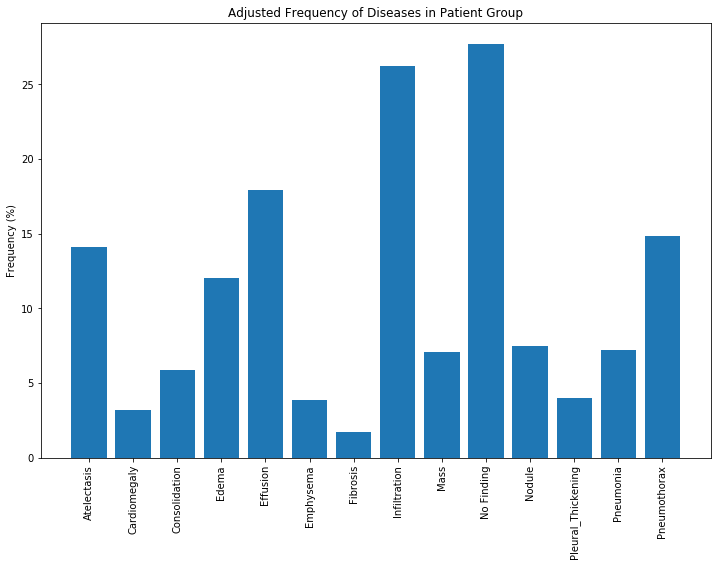

In [ ]:
label_counts = 100*np.mean(all_xray_df_bal[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [ ]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
all_xray_df['priority_vec'] = all_xray_df.apply(lambda x: [x[all_priorities].values], 1).map(lambda x: x[0])

In [ ]:
print(all_xray_df['disease_vec'].sample(3))
print(all_xray_df['priority_vec'].sample(3))

47168    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
66131    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
28315    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: disease_vec, dtype: object
83413    [0.0, 0.0, 0.0, 1.0]
58028    [1.0, 0.0, 0.0, 0.0]
13981    [0.0, 0.0, 1.0, 0.0]
Name: priority_vec, dtype: object


In [ ]:
all_xray_df_bal['disease_vec'] = all_xray_df_bal.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
all_xray_df_bal['priority_vec'] = all_xray_df_bal.apply(lambda x: [x[all_priorities].values], 1).map(lambda x: x[0])

In [ ]:
print(all_xray_df_bal['disease_vec'].sample(3))
print(all_xray_df_bal['priority_vec'].sample(3))

42980    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
52288    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
33462    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: disease_vec, dtype: object
44630    [0.0, 0.0, 1.0, 0.0]
74823    [0.0, 0.0, 1.0, 0.0]
33964    [0.0, 0.0, 1.0, 0.0]
Name: priority_vec, dtype: object


In [ ]:
import random
random.seed(100)
optimal_cut_off=[0.18122388,
 0.035741962,
 0.06785967,
 0.020848934,
 0.22941357,
 0.024166264,
 0.019189345,
 0.25657886,
 0.092459075,
 0.21176982,
 0.09132234,
 0.041559752,
 0.013046792,
 0.06757383]
thresholds_accuracy=optimal_cut_off

In [ ]:
df=all_xray_df.sample(40000)
from sklearn.model_selection import train_test_split
valid_df, test_df = train_test_split(df, 
                                   test_size = 0.5, 
                                   random_state = 2018,
                                   stratify = df['Priority Label'])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revie

In [ ]:
train_df = all_xray_df_bal

In [ ]:
print('train', train_df.shape, 'validation', valid_df.shape,'test', test_df.shape)

train (98245, 35) validation (20000, 35) test (20000, 35)


In [ ]:
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabelP'] = train_df['Priority Label']
print(train_df.sample(3))

             Image Index                            Finding Labels  \
108765  00003072_016.png  Effusion|Pleural_Thickening|Pneumothorax   
77393   00021610_009.png                         Infiltration|Mass   
195256  00029572_004.png                     Cardiomegaly|Effusion   

        Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
108765           16        3072           51              M            PA   
77393             9       21610           45              M            AP   
195256            4       29572           35              F            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
108765                 2500     2048                     0.168000  ...   
77393                  3056     2544                     0.139000  ...   
195256                 2021     2021                     0.194311  ...   

        Pneumonia  Pneumothorax priority1 priority2  priority3  priority4  \
108765        0.0           1.0     

In [ ]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df['newLabelP'] = valid_df['Priority Label']
print(valid_df.sample(3))

            Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
33970  00008890_000.png     No Finding            0        8890           38   
80820  00019863_000.png    Atelectasis            0       19863           34   
37154  00009802_000.png     No Finding            0        9802           42   

      Patient Gender View Position  OriginalImage[Width  Height]  \
33970              M            PA                 2500     2048   
80820              F            AP                 3056     2544   
37154              M            PA                 2834     2991   

       OriginalImagePixelSpacing[x  ...  Pneumonia  Pneumothorax priority1  \
33970                        0.168  ...        0.0           0.0       0.0   
80820                        0.139  ...        0.0           0.0       0.0   
37154                        0.143  ...        0.0           0.0       0.0   

      priority2  priority3  priority4  \
33970       0.0        0.0        1.0   
80820      

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['newLabelP'] = test_df['Priority Label']
print(test_df.sample(3))

            Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
98292  00025958_002.png     No Finding            2       25958            5   
69939  00017236_021.png          Edema           21       17236           46   
57393  00014238_000.png     No Finding            0       14238           55   

      Patient Gender View Position  OriginalImage[Width  Height]  \
98292              F            AP                 3056     2544   
69939              M            AP                 2500     2048   
57393              F            PA                 2618     2991   

       OriginalImagePixelSpacing[x  ...  Pneumonia  Pneumothorax priority1  \
98292                        0.139  ...        0.0           0.0       0.0   
69939                        0.168  ...        0.0           0.0       0.0   
57393                        0.143  ...        0.0           0.0       0.0   

      priority2  priority3  priority4  \
98292       0.0        0.0        1.0   
69939      

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
import tensorflow as tf
def queue_wait_cost(pmat,costs,arrivals,service):
    clambda = costs*arrivals
    rho = arrivals/service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)
def queue_wait_cost_priority(pmat,priority_costs,priority_arrivals,priority_service):
    clambda = priority_costs*priority_arrivals
    rho = priority_arrivals/priority_service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)
def queue_loss(y_true,y_pred):
    y_pred = y_pred/y_pred.sum(axis=1,keepdims=True)
    pmat = np.matmul(np.transpose(y_true),y_pred)
    pmat = pmat/pmat.sum(axis=1,keepdims=True)
    clambda = costs*arrivals
    rho = arrivals/service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)

def queue_loss_tensor(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #y_pred = tf.divide(y_pred,tf.reduce_sum(y_pred,axis=1,keepdims=True)+0.000000000001)
    pmat = tf.matmul(tf.transpose(y_true),y_pred)
    pmat = tf.divide(pmat,tf.reduce_sum(pmat,axis=1,keepdims=True)+0.000000000001)
    clambda = tf.reshape(tf.cast(tf.Variable(costs*arrivals),tf.float32),[1,14])
    rho = tf.reshape(tf.cast(tf.Variable(arrivals/service),tf.float32),[1,14])
    #print(rho.shape)
    clambda_pmat = tf.matmul(clambda,pmat)
    rho_pmat = tf.matmul(rho,pmat)
    vec1=1-tf.cumsum(rho_pmat,axis=1)
    #print(vec1)
    vec2=tf.roll(1-tf.cumsum(rho_pmat,axis=1),shift=1,axis=1)
    #print(vec2)
    vec2=tf.tensor_scatter_nd_update(vec2,indices=[[0,0]],updates=[1])
    #print(vec2)
    #print (tf.math.reciprocal(vec2))
    denom = tf.multiply(tf.math.reciprocal(vec1+0.00000000000001),tf.math.reciprocal(vec2+0.00000000000001))
    return tf.reshape(tf.reduce_sum(tf.multiply(clambda_pmat,denom)),[])
def queue_loss_tensor_priority(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #y_pred = tf.divide(y_pred,tf.reduce_sum(y_pred,axis=1,keepdims=True)+0.000000000001)
    pmat = tf.matmul(tf.transpose(y_true),y_pred)
    pmat = tf.divide(pmat,tf.reduce_sum(pmat,axis=1,keepdims=True)+0.000000000001)
    clambda = tf.reshape(tf.cast(tf.Variable(priority_costs*priority_arrivals),tf.float32),[1,n_priorities])
    rho = tf.reshape(tf.cast(tf.Variable(priority_arrivals/priority_service),tf.float32),[1,n_priorities])
    #print(rho.shape)
    clambda_pmat = tf.matmul(clambda,pmat)
    rho_pmat = tf.matmul(rho,pmat)
    vec1=1-tf.cumsum(rho_pmat,axis=1)
    #print(vec1)
    vec2=tf.roll(1-tf.cumsum(rho_pmat,axis=1),shift=1,axis=1)
    #print(vec2)
    vec2=tf.tensor_scatter_nd_update(vec2,indices=[[0,0]],updates=[1])
    #print(vec2)
    #print (tf.math.reciprocal(vec2))
    denom = tf.multiply(tf.math.reciprocal(vec1+0.00000000000001),tf.math.reciprocal(vec2+0.00000000000001))
    return tf.reshape(tf.reduce_sum(tf.multiply(clambda_pmat,denom)),[])
    

# Training the Model

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from keras import optimizers, callbacks, regularizers

Using TensorFlow backend.


In [ ]:
def MakeModel1(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model
def MakeModel2(n_priorities,IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels),activation = 'sigmoid'))
    model.add(Dense(n_priorities, activation = 'softmax'))
    return model
def MakeModel3(n_priorities,IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(n_priorities, activation = 'softmax'))
    return model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [ ]:
n_priorities=4

In [ ]:
lr = 0.0005
syntheticBatch = 256
imageSize = (512, 512)
colorMode = 'rgb'
channels = 3
batchSize = 32
batch = int(256 / batchSize)
STEPS_PER_EPOCH = 1000
EPOCHS = 20
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.queue_r_2_rho_0.95.june9.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]


train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabelP', 
                         class_mode = 'categorical',
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabelP', 
                        class_mode = 'categorical',
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize) # we can use much larger batches for evaluation


opt = tensorflow.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

Found 98245 validated image filenames belonging to 4 classes.
Found 20000 validated image filenames belonging to 4 classes.


In [ ]:
multi_disease_model_p = MakeModel3(n_priorities,imageSize, batchSize, channels)

In [ ]:
multi_disease_model_p.load_weights('xray_class_weights.best.queue_r_10.june1.hdf5')

In [ ]:
multi_disease_model_p.compile(optimizer = opt, loss = queue_loss_tensor_priority,
       run_eagerly=True,metrics = ['accuracy'])
history_p = multi_disease_model_p.fit_generator(train_gen,                           
              validation_data = valid_gen, 
              steps_per_epoch=1000,                                  
              epochs = 30, 
              callbacks = callbacks_list)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
  59/1000 [>.............................] - ETA: 39:46 - loss: 28.3768 - accuracy: 0.3841

In [53]:
history_p.history

{'loss': [28.17603302001953,
  34.36729431152344,
  35.99800491333008,
  35.41164016723633,
  36.13084411621094,
  36.094932556152344],
 'accuracy': [0.335875004529953,
  0.17806249856948853,
  0.14687392115592957,
  0.1641875058412552,
  0.15006250143051147,
  0.14787499606609344],
 'val_loss': [20.669105529785156,
  27.09619140625,
  26.5914306640625,
  26.97545623779297,
  26.93218994140625,
  26.79911231994629],
 'val_accuracy': [0.23999999463558197,
  0.048250000923871994,
  0.048250000923871994,
  0.048250000923871994,
  0.048250000923871994,
  0.048250000923871994]}